## Learning Objectives

Today we learn how to test out multiple hypothesis sets using a validation set. We show we can use this in practice on a real dataset and show a full episode of learning from start to finish

## Validation Set

Something that we did not go over before was the validation set. We saw what a big difference in error we got with the test set, and we learned that we cannot trust the error we get on the training set. But the problem is that we cannot use the test set but once. So this would be fine if we were testing a single hypothesis, but this would not work if we were testing a series of different hypotheses against each other (consider KNN with K as 3 and 4). So what do we do?

In practice we will split our data into three sets one used for training, one used to experiment on, and one to hold out until the end to test on. 

So what gives? We just showed that as we try multiple hypotheses the quality of the estimate decreases.

Well as we just saw in the previous lesson and as we will see later on, when we train on data we will in general test infinite hypotheses. And in this case the error bound becomes far worse. 

So we have three data splits for three cases:

1. Train data: we use this to test infinite hypotheses
2. Validation data: we use this to test finite hypotheses
3. Test data: we use this to test a single hypothesis

Let's walk through doing this below:

In [31]:
from sklearn.datasets import load_breast_cancer

breast_cancer_data = load_breast_cancer()

In [33]:
print breast_cancer_data['DESCR']

Breast Cancer Wisconsin (Diagnostic) Database

Notes
-----
Data Set Characteristics:
    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry 
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 3 is Mean Radius, field
        13 is Radius SE, field 23 is Worst Radius.

        

In [34]:
print breast_cancer_data['data'].shape
print breast_cancer_data['target'].shape
print breast_cancer_data['feature_names']
print breast_cancer_data['target_names']

(569, 30)
(569,)
['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']
['malignant' 'benign']


In [37]:
# now we split the data
from sklearn.model_selection import train_test_split

# we make our test set
X_train, X_test, y_train, y_test = train_test_split(breast_cancer_data['data'], breast_cancer_data['target'], test_size=0.2, random_state=1)

# and we make our validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

In [38]:
print X_train.shape, X_val.shape, X_test.shape

(364, 30) (91, 30) (114, 30)


## In practice

So let's say that we wanted to try KNN, but we wanted to try multiple values for K, what could we do...

In this case we would train multiple models and try them all on the validation set!

First let's do some feature engineering (remember we only train our feature engineering on the training data!)

In [39]:
from sklearn.neighbors import KNeighborsClassifier

# we can try 3, 4 and 5 for the number of neighbors
cls = KNeighborsClassifier(n_neighbors=1, weights='uniform')

In [40]:
cls.fit(X_train, y_train)

# wow so good! (well no kidding right!)
cls.score(X_train, y_train)

1.0

In [41]:
# Now we try it on the validation data
cls.score(X_val, y_val)

# that is more like it

0.89010989010989006

In [42]:
from sklearn.neighbors import KNeighborsClassifier

# we can try 3, 4 and 5 for the number of neighbors
cls = KNeighborsClassifier(n_neighbors=3, weights='uniform')

cls.fit(X_train, y_train)

print cls.score(X_train, y_train)

print cls.score(X_val, y_val)

0.950549450549
0.934065934066


In [43]:
from sklearn.neighbors import KNeighborsClassifier

# we can try 3, 4 and 5 for the number of neighbors
cls = KNeighborsClassifier(n_neighbors=5, weights='uniform')

cls.fit(X_train, y_train)

print cls.score(X_train, y_train)

print cls.score(X_val, y_val)

0.942307692308
0.912087912088


In [44]:
# and now that we found a great model, let's try it on the test set:
cls = KNeighborsClassifier(n_neighbors=3, weights='uniform')

cls.fit(X_train, y_train)

print cls.score(X_test, y_test)

0.938596491228


And finally we can construct a confidence interval based on the above results:

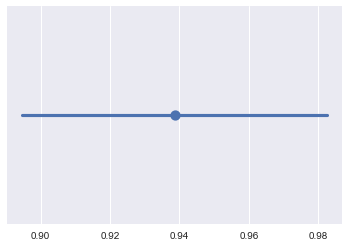

In [46]:
%matplotlib inline
import seaborn as sns

sns.pointplot(cls.predict(X_test) == y_test)

## Learning Objectives

Today we learn how to test out multiple hypothesis sets using a validation set. We show we can use this in practice on a real dataset and show a full episode of learning from start to finish

## Comprehension Questions

1.	What is the tradeoff by having a validation set? What about a test set?
2.	What is a good size for a validation set?
3.	How many hypotheses should you try on your validation set?
4.	Order the following: score on your test set, on validation, on training
